In [1]:
import cvxpy as cp, numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
def makeA2(x,y):
    # not used except by makeA1
    u = x.reshape((-1,1))
    v = y.reshape((-1,1))
    return (u*v.T+v*u.T) / 2.  # ip(u,v)

makeA1 = lambda x: makeA2(x,x) # norm(x)

In [3]:
def solvePEP(N):
    
    dimM = 2*N + 5
    dimG = N + 1
    nbPts = N + 2
    
    # encoding vectors
    x = np.zeros((nbPts, dimM))  # x_0, ..., x_N, x^*
    x_ = np.zeros((nbPts-1, dimM))
    F = np.zeros((nbPts, dimM))
    dg = np.zeros((nbPts, dimM))
    g = np.zeros((nbPts, dimG))
    g[:-1,:] = np.eye(nbPts-1)

    x[0,0] = x_[0,1] = 1
    F[:,2:nbPts+2] = np.eye(nbPts)
    dg[:-1,1-nbPts:] = np.eye(nbPts-1)
    dg[-1,:] = -F[-1,:]   # 0 \in F(x^*) + dg(x^*)
    # g[:-1,:] = np.eye(nbPts-1)

    # encoding GRAAL

    for i in range(N):
        x[i+1,:] = x_[i,:] - la*(F[i,:] + dg[i,:])
        x_[i+1,:] = ((phi-1)*x[i+1,:] + x_[i,:])/phi
        
    M = cp.Variable((dimM, dimM), PSD=True)
    G = cp.Variable((dimG, 1))

    # initial radius constraint
    constraints = {'radius': cp.trace(M@((phi+1)*makeA1(x_[1,:] - x[-1,:]) + (phi/2)*makeA1(x[1,:] - x[0,:]) )) <= R}
    
    for i in range(nbPts):
        for j in range(nbPts):
            if i != j:

                # monotonicity
                constraints[f'Monotonicty @ ({i},{j})'] = (F[i,:] - F[j,:]) @ M @ (x[i,:] - x[j,:]) >= 0

                # Lipschitz
                constraints[f'Lipzchitz @ ({i},{j})'] = cp.trace(M@(makeA1(F[i,:] - F[j,:]))) <= L**2*cp.trace(M@makeA1(x[i,:] - x[j,:]))


            if i < nbPts-1 and i + 1 != j:
                # prox-ineq
                constraints[f'prox-ineq @ ({i},{j})'] = (x[i+1,:] - x_[i,:] + la*F[i,:]) @ M @ (x[j,:] - x[i+1,:]) >= la*(g[j,:] - g[i+1,:])@G

        if i > 0:
            # optimallity condition
            constraints[f'opt condition @ ({i})'] = F[0,:] @ M @ (x[i,:] - x[0,:]) >= (g[0,:] - g[i,:])@G
    
    # x[-1,:] = x^* but x_[-1,:] = x_N
    obj = cp.Maximize(cp.trace(M@((phi+1)*makeA1(x_[-1,:]-x[-1,:]) + (phi/2)*makeA1(x[-2,:] - x[-3,:]))))

    prob = cp.Problem(obj, constraints.values())
    prob.solve(solver=cp.MOSEK)
    return obj.value

In [4]:
# paramaters

L = 1
N = 3
R = 1
phi = (1+np.sqrt(5))/2 # golden ratio
la = phi/(2*L) # step-size

In [5]:
dimM = 2*N + 5
dimG = N + 1
nbPts = N + 2

In [6]:
# encoding vectors

x = np.zeros((nbPts, dimM))  # x^*, x_0, ..., x_N
x_ = np.zeros((nbPts-1, dimM))
F = np.zeros((nbPts, dimM))
dg = np.zeros((nbPts, dimM))
g = np.eye(nbPts)

x[0,0] = x_[0,1] = 1
F[:,2:nbPts+2] = np.eye(nbPts)
dg[:-1,1-nbPts:] = np.eye(nbPts-1)
dg[-1,:] = -F[-1,:]   # 0 \in F(x^*) + dg(x^*)

# encoding GRAAL

for i in range(N):
    x[i+1,:] = x_[i,:] - la*(F[i,:] + dg[i,:])
    x_[i+1,:] = ((phi-1)*x[i+1,:] + x_[i,:])/phi

In [7]:
M = cp.Variable((dimM, dimM), PSD=True)
G = cp.Variable((nbPts, 1))

# initial radius constraint
constraints = {'radius': cp.trace(M@((phi+1)*makeA1(x_[1,:] - x[-1,:]) + (phi/2)*makeA1(x[1,:] - x[0,:]) )) <= R}
# constraints = {'radius 1': cp.trace(M@(makeA1(x[0,:] - x[-1,:]))) <= R}
# constraints['radius 2'] = cp.trace(M@(makeA1(x_[0,:] - x[-1,:]))) <= R

for i in range(nbPts):
    for j in range(nbPts):
        if i != j:
            
            # monotonicity
            constraints[f'Monotonicty @ ({i},{j})'] = (F[i,:] - F[j,:]) @ M @ (x[i,:] - x[j,:]) >= 0
            
            # Lipschitz
            constraints[f'Lipzchitz @ ({i},{j})'] = cp.trace(M@(makeA1(F[i,:] - F[j,:]))) <= L**2 *cp.trace(M@makeA1(x[i,:] - x[j,:]))
        
        
        if i < nbPts-1 and i + 1 != j:
            # prox-ineq
            constraints[f'prox-ineq @ ({i},{j})'] = (x[i+1,:] - x_[i,:] + la*F[i,:]) @ M @ (x[j,:] - x[i+1,:]) >= la*(g[j,:] - g[i+1,:])@G
    
    if i < nbPts-1:
        # optimallity condition
        constraints[f'opt condition @ ({i})'] = F[-1,:] @ M @ (x[i,:] - x[-1,:]) >= (g[-1,:] - g[i,:])@G

# original constraints, these give opt value ~= 1 (in the N=2 case)
# constraints = [cp.trace(M@makeA2(F[1,:] - F[-1,:], x[1,:] - x[-1,:])) >= 0, 
#                cp.trace(M@makeA1(F[0,:] - F[1,:])) <= L**2 * cp.trace(M@makeA1(x[0,:] - x[1,:])),
#                cp.trace(M@makeA2(x[2,:] - x_[1,:] + la*F[1,:], x[-1,:] - x[2,:])) >= la*(g[2,:] - g[-1,:])@G,
#                cp.trace(M@makeA2(x[1,:] - x_[0,:] + la*F[0,:], x[2,:] - x[1,:])) >= la*(g[1,:] - g[2,:])@G,
#                cp.trace(M@makeA2(F[-1,:], x[1,:] - x[-1,:])) >= (g[-1,:] - g[1,:])@G,
#                cp.trace(M@((phi+1)*makeA1(x_[1,:] - x[-1,:]) + (phi/2)*makeA1(x[1,:] - x[0,:]))) == R]

In [8]:
# x[-1,:] = x^* but x_[-1,:] = x_N
obj = cp.Maximize(cp.trace(M@((phi+1)*makeA1(x_[-1,:]-x[-1,:]) + (phi/2)*makeA1(x[-2,:] - x[-3,:]))))
# obj = cp.Maximize(cp.trace(M@makeA1(x[-2,:] - x[-1,:]))) # || x_N - x^* ||^2
prob = cp.Problem(obj, constraints.values())
prob.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 19 02:18:56 PM: Your problem has 126 variables, 61 constraints, and 0 parameters.
(CVXPY) Jul 19 02:18:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 19 02:18:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 19 02:18:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 19 02:18:56 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 19 02:18:56 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> C

0.4761681102285322

In [9]:
# objective
print('PEP value: {:.4f}'.format(obj.value))
# print('Theo value?: {:.4f}'.format(R/la/N))

for name,c in constraints.items():
    if not np.isclose(c.dual_value, 0, atol=1e-4):
        print('\t{}: {:.4f}'.format(name, float(c.dual_value)))

PEP value: 0.4762
	radius: 0.4762
	Monotonicty @ (0,1): 0.0073
	Lipzchitz @ (0,1): 0.2616
	Monotonicty @ (0,2): 0.0739
	Lipzchitz @ (0,2): 0.0766
	prox-ineq @ (0,2): 1.5881
	Monotonicty @ (0,3): 0.0364
	Lipzchitz @ (0,3): 0.0052
	Monotonicty @ (0,4): 0.0444
	Lipzchitz @ (0,4): 0.0089
	prox-ineq @ (1,1): 1.1542
	Monotonicty @ (1,2): 0.0627
	Lipzchitz @ (1,2): 0.6134
	Monotonicty @ (1,3): 0.3686
	Lipzchitz @ (1,3): 0.4176
	prox-ineq @ (1,3): 1.6135
	Monotonicty @ (1,4): 0.0223
	Lipzchitz @ (1,4): 0.0011
	prox-ineq @ (1,4): 1.2607
	prox-ineq @ (2,1): 0.3956
	prox-ineq @ (2,2): 2.0537
	Monotonicty @ (2,3): 0.0858
	Lipzchitz @ (2,3): 0.6149
	Monotonicty @ (2,4): 0.0029
	Lipzchitz @ (2,4): 0.0017
	prox-ineq @ (2,4): 1.8489
	prox-ineq @ (3,1): 0.0383
	prox-ineq @ (3,2): 0.3866
	prox-ineq @ (3,3): 2.6848
	Monotonicty @ (3,4): 0.0052
	Lipzchitz @ (3,4): 0.0337


In [10]:
N_RANGE = range(1,21)

In [11]:
results = [solvePEP(N) for N in tqdm(N_RANGE)]

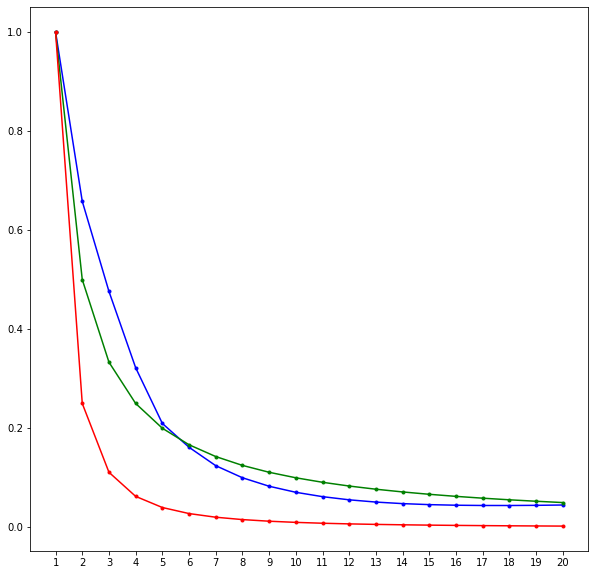

In [12]:
fig = plt.figure(figsize=(10,10))
plt.plot(N_RANGE, results, 'b.-')
plt.xticks(N_RANGE)

# f = np.vectorize(lambda x: (1/2)**x)
# plt.plot(N_RANGE, f(N_RANGE), 'r.-')

f = np.vectorize(lambda x: 1/x)
plt.plot(N_RANGE, f(N_RANGE), 'g.-')

f = np.vectorize(lambda x: 1/x**2)
plt.plot(N_RANGE, f(N_RANGE), 'r.-')

plt.show()